<a href="https://colab.research.google.com/github/webdevserv/kaixo/blob/master/Idoia_Aurpegia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install Dlib**

In [51]:
!apt update
!apt install -y cmake
!pip install dlib

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Get:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Get:14 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic/main amd64 Packages [863 kB]
Fetched 879 kB in 3s (349 kB/s

In [0]:
#utils.py

from PIL import Image
import matplotlib.pyplot as plt
import requests
import io, re
import numpy as np

def find_url(string):
    """Find if a string contains an URL"""
    # findall() has been used
    # with valid conditions for urls in string
    url = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', string)
    if len(url) > 0:
      return True

def read_url_or_local_image(path, im_format = 'cv2'):
  """Convert URL to OpenCV/PIL Image"""
  if find_url(path):
      r = requests.get(path)
      pil_im = Image.open(io.BytesIO(r.content))
  else:
      pil_im = Image.open(path)
  
  if im_format is 'cv2':
    image = cv2.cvtColor(np.array(pil_im), cv2.COLOR_RGB2BGR)
    return image
  else:
    return pil_im

In [55]:
# cd into directory
cd idoia_aurpegia

[Errno 2] No such file or directory: 'idoia_aurpegia'
/content/idoia_aurpegia


In [0]:
# Import modules
import sys, cv2, dlib, time
import numpy as np
import faceBlendCommon as fbc
import matplotlib.pyplot as plt

In [0]:
# Read images
img1 = read_url_or_local_image('/content/idoia_aurpegia/inputimg.jpg')
img2 = read_url_or_local_image('/content/idoia_aurpegia/trumpimg.jpg')

im1Display = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
im2Display = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

img1Warped = np.copy(img2)

In [0]:
# Convert to RGB
im1Display = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
im2Display = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

img1Warped = np.copy(img2)

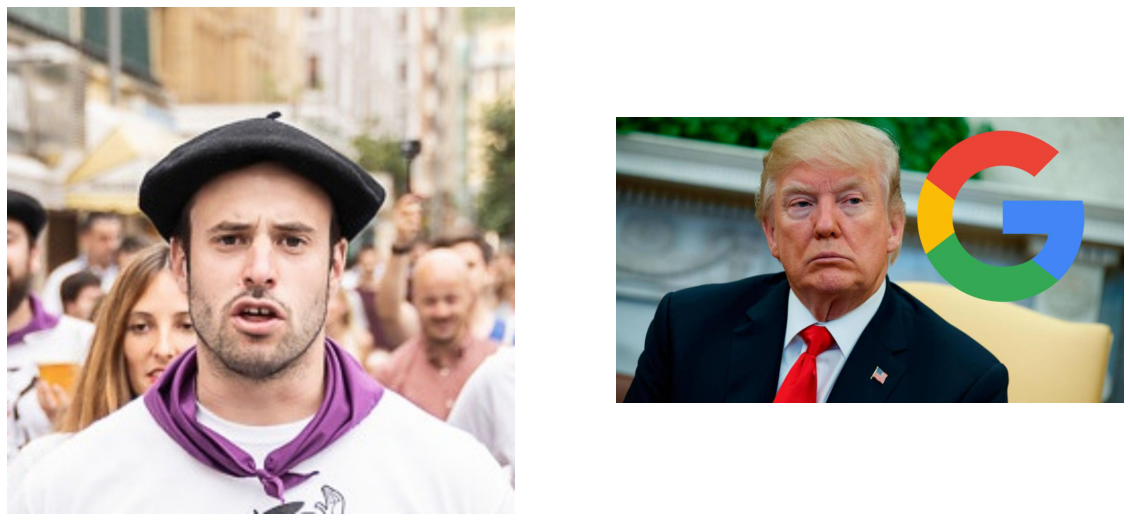

In [61]:
# Display Images 
plt.figure(figsize = (20,10))
plt.subplot(121); plt.imshow(im1Display); plt.axis('off');
plt.subplot(122); plt.imshow(im2Display); plt.axis('off');

In [29]:
!pip install --upgrade imutils

Requirement already up-to-date: imutils in /usr/local/lib/python3.6/dist-packages (0.5.3)


In [0]:
# Initialize the dlib facial landmakr detector
# *.dat file has to be in idoia_aurpegia folder
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
# Read array of corresponding points
points1 = fbc.getLandmarks(detector, predictor, img1)
points2 = fbc.getLandmarks(detector, predictor, img2)

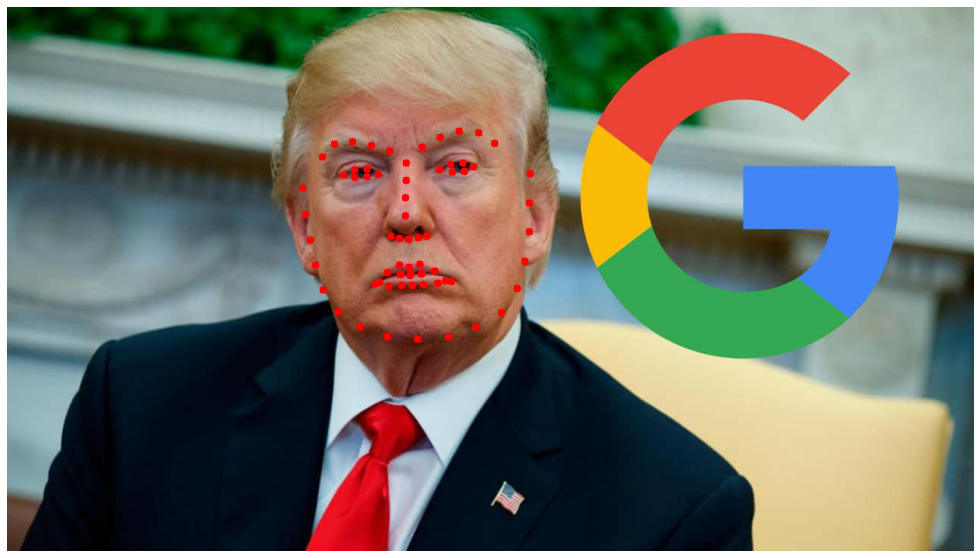

In [64]:
# Clone 
imTemp = im2Display.copy()
for p in points2:
    cv2.circle(imTemp, p, 5, (255,0,0), -1)

plt.figure(figsize = (20,10)); plt.imshow(imTemp); plt.axis('off');

In [0]:
# Find convex hull
hullIndex = cv2.convexHull(np.array(points2).astype(np.int32), returnPoints=False) # add .astype(np.int32) to fix TypeError: data type = 9 not supported

# Create convex hull lists
hull1 = []
hull2 = []
for i in range(0, len(hullIndex)):
    hull1.append(points1[hullIndex[i][0]])
    hull2.append(points2[hullIndex[i][0]])


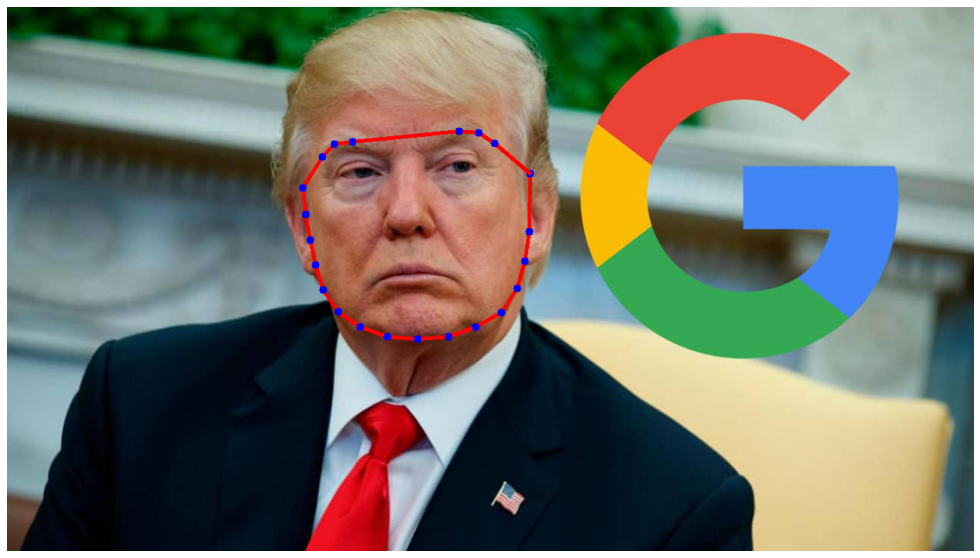

In [66]:
# Display hulls

imTemp = im2Display.copy()
numPoints = len(hull2)
for i in range(0, numPoints):
    cv2.line(imTemp, hull2[i], hull2[(i+1)%numPoints], (255,0,0), 3)
    cv2.circle(imTemp, hull2[i], 5, (0,0,255), -1)
plt.figure(figsize = (20,10)); plt.imshow(imTemp); plt.axis('off');

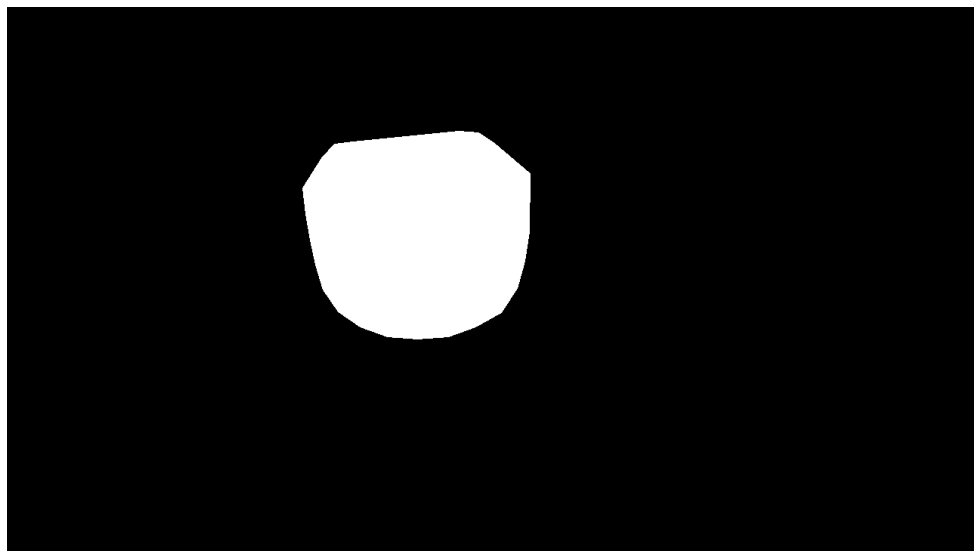

In [67]:
# Calculate Mask for Seamless cloning
hull8U = []
for i in range(0, len(hull2)):
    hull8U.append((hull2[i][0], hull2[i][1]))

mask = np.zeros(img2.shape, dtype=img2.dtype)
cv2.fillConvexPoly(mask, np.int32(hull8U), (255, 255, 255))

# Find Centroid
m = cv2.moments(mask[:,:,1])
center = (int(m['m10']/m['m00']), int(m['m01']/m['m00']))

plt.figure(figsize = (20,10)); plt.imshow(mask); plt.axis('off');


In [0]:
# Find Delaunay traingulation for convex hull points
sizeImg2 = img2.shape    
rect = (0, 0, sizeImg2[1], sizeImg2[0])

dt = fbc.calculateDelaunayTriangles(rect, hull2)

# If no Delaunay Triangles were found, quit
if len(dt) == 0:
    quit()

In [0]:
#display triangulation
imTemp1 = im1Display.copy()
imTemp2 = im2Display.copy()

tris1 = []
tris2 = []
for i in range(0, len(dt)):
    tri1 = []
    tri2 = []
    for j in range(0, 3):
        tri1.append(hull1[dt[i][j]])
        tri2.append(hull2[dt[i][j]])

    tris1.append(tri1)
    tris2.append(tri2)

cv2.polylines(imTemp1,np.array(tris1).astype(np.int32),True,(0,0,255),2);
cv2.polylines(imTemp2,np.array(tris2).astype(np.int32),True,(0,0,255),2);


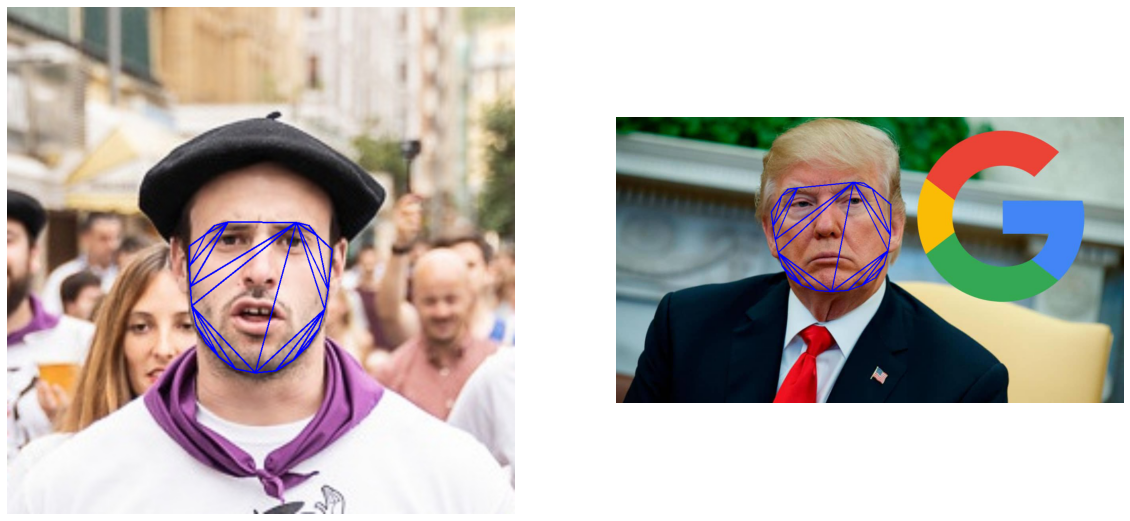

In [71]:
plt.figure(figsize = (20,10)); 
plt.subplot(121); plt.imshow(imTemp1); plt.axis('off');
plt.subplot(122); plt.imshow(imTemp2); plt.axis('off');

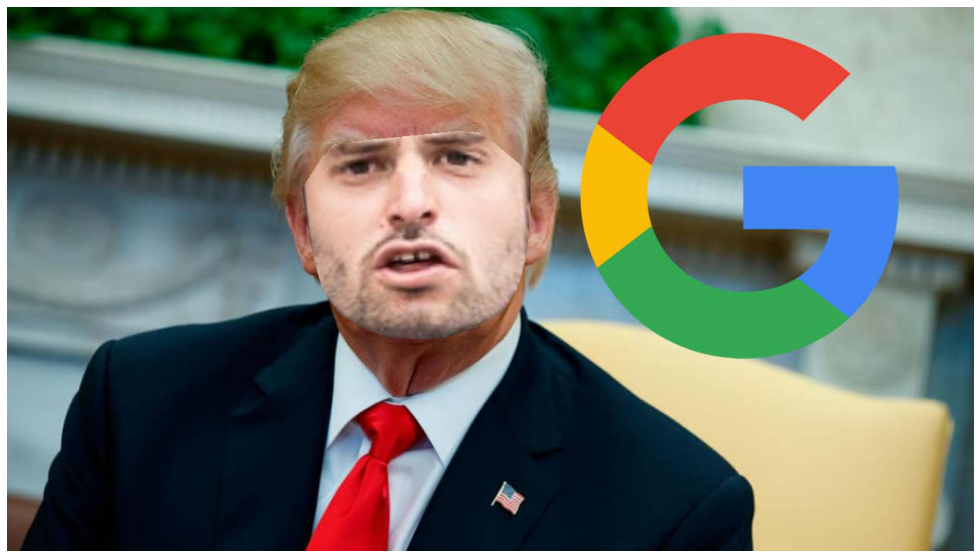

In [46]:
# Apply affine transformation to Delaunay triangles
for i in range(0, len(tris1)):
    fbc.warpTriangle(img1, img1Warped, tris1[i], tris2[i])

plt.figure(figsize=(20,10));
plt.imshow(np.uint8(img1Warped)[:,:,::-1]); plt.axis('off');


In [0]:
# Clone seamlessly.
output = cv2.seamlessClone(np.uint8(img1Warped), img2, mask, center, cv2.NORMAL_CLONE)


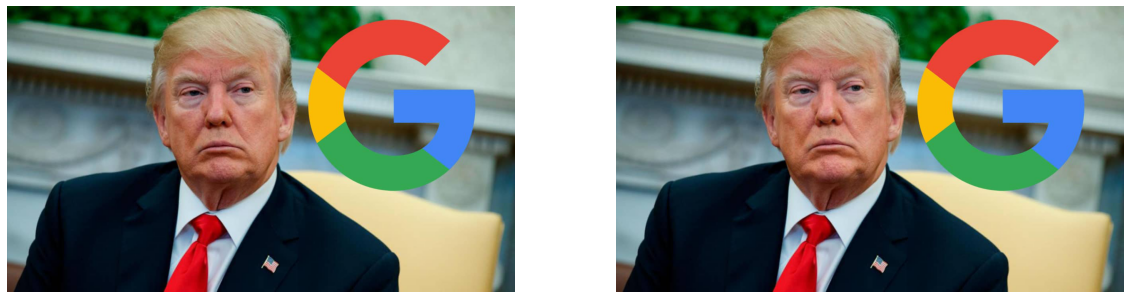

In [73]:
# Display result
plt.figure(figsize=(20,10))
plt.subplot((121)); plt.imshow(np.uint8(img1Warped)[:,:,::-1]); plt.axis('off');
plt.subplot((122)); plt.imshow(output[:,:,::-1]); plt.axis('off');